<h1><center> Fraud Analytics using Predictive and Social Network Techniques (CS6890) </center></h1>
<h2><center> The Trust-Rank Algorithm </center></h2>

<h3>Team members:</h3>
<center>
    <h4>
        <table>
            <tr>
                <th> Name </th>
                <th> Roll Number </th>
            </tr>
            <tr>
                <td> Kritik Agarwal </td>
                <td> CS23MTECH11009 </td>
            </tr>
            <tr>
                <td> Raghavendra Kulkarni </td>
                <td> CS23MTECH11016 </td>
            </tr>
            <tr>
                <td> Arnab Ghosh </td>
                <td> CS23MTECH11025 </td>
            </tr>
            <tr>
                <td> Shagun Sharma </td>
                <td> CS23MTECH14013 </td>
            </tr>
            <tr>
                <td> Trishita Saha </td>
                <td> CS23MTECH14016 </td>
            </tr>
        </table>
    </h4>
</center>

### Import the Required Packages

In [1]:
# Packages for Data Handling
import pandas as pd

# Packages for Graph Handling
import networkx as nx

# Packages for Result Interpretation
import matplotlib.pyplot as plt

### Load the Payments data and create the graph

In [2]:
# Create a MultiDiGraph
graph = nx.MultiDiGraph()

# Open the file and assign a file handler
with open('Payments.csv', 'r') as file:

    # Read and ignore the header line
    line = file.readline()

    # For all the following lines
    for line in file.readlines():

        # Split the line into sender, receiver and amount of the payment
        sender, receiver, amount = map(int, line.split(','))

        # Add the payment as an edge between the nodes denoting the sender and the receiver
        graph.add_edge(sender, receiver, weight = amount)

### Normalize the out-going edge weights to sum to 1

In [3]:
# For every node in the graph
for node in graph.nodes():

    # Calculate the sum of edge weights of all outgoing edges
    total_weight = sum(data['weight'] for _, _, data in graph.edges(node, data=True))
    
    # Ignore the vertex with no outgoing edges
    if total_weight == 0:
        continue

    # For every outgoing edge of the node
    for neighbor, _, data in graph.edges(node, data=True):

        # Divide the edge weight by the sum to normalize
        data['weight'] /= total_weight

### Load the Bad senders data

In [4]:
# Initialize a set to store the known bad senders
bad_senders = set()

# Open the file and assign a file handler
with open('bad_sender.csv', 'r') as file:

    # Read and ignore the header line
    line = file.readline()

    # For all the following lines
    for line in file.readlines():

        # Add the bad sender id to the set
        bad_senders.add(int(line))

# Store the total number of bad senders
num_bad_senders = len(bad_senders)

### Run the Trust rank algorithm

In [5]:
# Initialize the seed scores for the nodes
score = {node : (1/num_bad_senders if node in bad_senders else 0) for node in graph.nodes()}

# Set the iteration parameters
max_iterations, alpha, damping_factor, tolerance = 2000, 1/len(graph.nodes()), 0.85, 10e-19

# In every iteration
for iteration in range(max_iterations):
    
    # Initialize the new scores for the nodes
    new_score = {node : (1/num_bad_senders if node in bad_senders else 0) for node in graph.nodes()}
    
    # For every node of the graph
    for node in graph.nodes():

        # For every receiving neighbor of the node
        for neighbor, edges in graph[node].items():
                
                # For every edge between the node and the receiving neighbor
                for edge in edges.values():

                    # Update the score of the neighbor
                    new_score[neighbor] += score[node]*edge.get('weight', 0)
    
    # Include the damping factor and smoothing value for the node scores
    new_score = {node : (new_score[node]*damping_factor + alpha*(1 - damping_factor)) for node in graph.nodes()}
    
    # Check for convergence
    if all([abs(new_score[node] - score[node]) < tolerance for node in graph.nodes()]):
        break
    
    # Shift the scores for next iteration
    score = new_score

### Set the threshold and identify the Bad senders

In [6]:
# Set the threshold for identifying bad senders
threshold = min([score[node] for node in bad_senders])

# Identify the new bad senders based on the threshold
new_bad_senders = set([node for node in graph.nodes() if score[node] >= threshold])

# Print the new bad sender IDs
print('Now there are {} bad senders.'.format(len(new_bad_senders)))
print('They are {}'.format(', '.join(map(str, new_bad_senders))))
print('The newly identified {} bad senders are {}'.format(len(new_bad_senders) - len(bad_senders), ', '.join(map(str, new_bad_senders.difference(bad_senders)))))

Now there are 37 bad senders.
They are 1668, 1031, 1161, 1034, 1038, 1041, 1042, 1173, 1303, 1944, 1048, 1562, 1050, 1821, 1836, 1201, 1076, 1205, 1210, 1084, 1086, 1088, 1094, 1480, 1099, 1489, 1626, 1122, 1256, 1259, 1007, 1393, 1138, 1011, 1013, 1144, 1147
The newly identified 17 bad senders are 1088, 1122, 1094, 1480, 1038, 1144, 1041, 1201, 1138, 1011, 1173, 1205, 1626, 1013, 1050, 1084, 1086


In [7]:
# Extract the bad sender scores and sort them in reverse order
bad_scores = list(score.items())
bad_scores.sort(key = lambda x : x[1], reverse = True)

# Print the top 10 bad sender scores
print('The top 10 scores of bad senders are : \n{}'.format('\n'.join(map(str, bad_scores[:10]))))

The top 10 scores of bad senders are : 
0.1860087378457204
0.17730705598268548
0.17410612265169015
0.12414467292186009
0.09687094123706333
0.09643505791988981
0.07704341088085703
0.07295612362538079
0.06249344189009486
0.06243371355838374


### Result Visualizations

In [8]:
# A function that returns the score of a sender with given ID
def findScore(index):
    return score[index]

# A function to check if a bad sender was already known or newly discovered
def isNew(index):
    return index in new_bad_senders.difference(bad_senders)

# Data aggregation for plotting
data = pd.read_csv('Payments.csv')
agg = pd.DataFrame(data.groupby('Sender', sort = False).sum()['Amount'])
agg['Score'] = agg.index.map(findScore)
agg['isNew'] = agg.index.map(isNew)

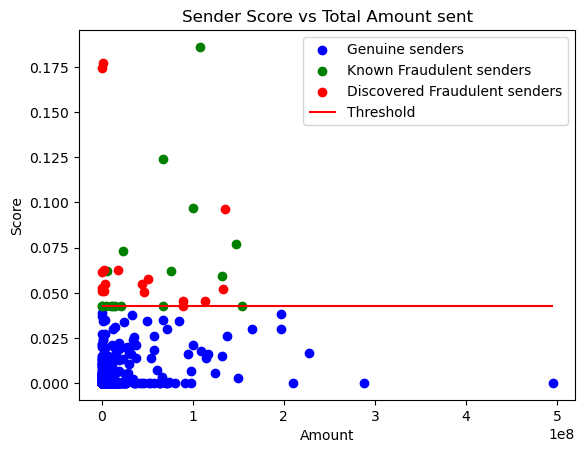

In [9]:
# Plot the graph
plt.scatter(agg.loc[agg.Score < threshold].Amount, agg.loc[agg.Score < threshold].Score, color = 'b', label = 'Genuine senders')
plt.scatter(agg.loc[(agg.Score >= threshold) & (agg.isNew == False)].Amount, agg.loc[(agg.Score >= threshold) & (agg.isNew == False)].Score, color = 'g', label = 'Known Fraudulent senders')
plt.scatter(agg.loc[(agg.Score >= threshold) & (agg.isNew == True)].Amount, agg.loc[(agg.Score >= threshold) & (agg.isNew == True)].Score, color = 'r', label = 'Discovered Fraudulent senders')
plt.xlabel('Amount')
plt.ylabel('Score')
plt.title('Sender Score vs Total Amount sent')
plt.hlines(y = [threshold], xmin = 0, xmax = agg.Amount.max(), colors = 'r', label = 'Threshold')
plt.legend()
plt.savefig('Results.png')
plt.show()